In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from tqdm import tqdm
import json
import os

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# class CausalLinearAttention(nn.Module):
#     def __init__(self, n_embd, n_head):
#         super().__init__()
#         assert n_embd % n_head == 0
#         self.n_head = n_head
#         self.head_dim = n_embd // n_head

#         self.c_attn = nn.Linear(n_embd, 3 * n_embd)
#         self.c_proj = nn.Linear(n_embd, n_embd)
#         self.eps = 1e-6

#     def feature_map(self, x):
#         #elu(x) + 1
#         # return F.elu(x) + 1.0
#         return F.relu(x) + 1e-6
#         # return torch.cat([F.elu(x) + 1.0, x**2], dim=-1)

#     def forward(self, x):
#         B, T, C = x.size()

#         qkv = self.c_attn(x)
#         q, k, v = qkv.view(B, T, 3, self.n_head, self.head_dim).unbind(2)

#         Q = self.feature_map(q)
#         K = self.feature_map(k)

#         kv = torch.einsum("bxhd,bxhm->bxhdm", K, v)

#         kv_cumsum = torch.cumsum(kv, dim=1)
#         k_cumsum = torch.cumsum(K, dim=1)

#         numerator = torch.einsum("bxhd,bxhdm->bxhm", Q, kv_cumsum)

#         denominator = torch.einsum("bxhd,bxhd->bxh", Q, k_cumsum)
#         denominator = denominator.unsqueeze(-1) + self.eps

#         output = numerator / (denominator.clamp(self.eps))

#         output = output.contiguous().view(B, T, C)
#         return self.c_proj(output)

# class FeedForward(nn.Module):
#     def __init__(self, n_embd):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(n_embd, 4 * n_embd),
#             nn.GELU(),
#             nn.Linear(4 * n_embd, n_embd),
#         )

#     def forward(self, x):
#         return self.net(x)

# class LinearBlock(nn.Module):
#     def __init__(self, n_embd, n_head):
#         super().__init__()
#         self.ln1 = nn.LayerNorm(n_embd)
#         self.attn = CausalLinearAttention(n_embd, n_head)
#         self.ln2 = nn.LayerNorm(n_embd)
#         self.mlp = FeedForward(n_embd)

#     def forward(self, x):
#         x = x + self.attn(self.ln1(x))
#         x = x + self.mlp(self.ln2(x))
#         return x

# class LinearTransformerModel(nn.Module):
#     def __init__(self, n_dims, n_positions, n_embd=256, n_layer=6, n_head=4):
#         super().__init__()
#         self.n_positions = n_positions
#         self.n_dims = n_dims
#         self.name = f"linear_embd={n_embd}_layer={n_layer}_head={n_head}"

#         self._read_in = nn.Linear(n_dims, n_embd)
#         self.blocks = nn.ModuleList([
#             LinearBlock(n_embd, n_head) for _ in range(n_layer)
#         ])
#         self.ln_f = nn.LayerNorm(n_embd)
#         self._read_out = nn.Linear(n_embd, 1)

#     def _combine(self, xs_b, ys_b):
#         bsize, points, dim = xs_b.shape
#         ys_b_wide = torch.cat(
#             (ys_b.view(bsize, points, 1), torch.zeros(bsize, points, dim - 1, device=ys_b.device)),
#             axis=2,
#         )
#         zs = torch.stack((xs_b, ys_b_wide), dim=2)
#         zs = zs.view(bsize, 2 * points, dim)
#         return zs

#     def forward(self, xs, ys, inds=None):
#         if inds is None: inds = torch.arange(ys.shape[1])
#         else: inds = torch.tensor(inds)

#         zs = self._combine(xs, ys)
#         x = self._read_in(zs)

#         for block in self.blocks:
#             x = block(x)

#         x = self.ln_f(x)
#         prediction = self._read_out(x)

#         predictions = prediction[:, ::2, 0]
#         return predictions[:, inds]




In [ ]:
def relu_squared_feature_map(x):
    # φ(x) = ReLU(x)^2, keeps positivity but tames extremes
    return F.relu(x) ** 2


class CausalLinearAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, feature_map=relu_squared_feature_map, eps=1e-6):
        super().__init__()
        assert embed_dim % num_heads == 0
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.feature_map = feature_map
        self.eps = eps

        self.qkv_proj = nn.Linear(embed_dim, 3 * embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        """
        x: (B, T, E)
        returns: (B, T, E)
        """
        B, T, E = x.shape
        H = self.num_heads
        Dh = self.head_dim

        qkv = self.qkv_proj(x)          # (B, T, 3E)
        q, k, v = qkv.chunk(3, dim=-1)

        def reshape_heads(t):
            return t.view(B, T, H, Dh).transpose(1, 2)  # (B, H, T, Dh)

        q = reshape_heads(q)
        k = reshape_heads(k)
        v = reshape_heads(v)

        # Stronger scaling to keep things well-behaved
        scale = Dh ** 0.5
        q = q / scale
        k = k / scale

        q_prime = self.feature_map(q)   # (B, H, T, Dh)
        k_prime = self.feature_map(k)   # (B, H, T, Dh)

        # Causal prefix sums
        z = k_prime.cumsum(dim=2)       # (B, H, T, Dh)

        kv = k_prime.unsqueeze(-1) * v.unsqueeze(-2)   # (B, H, T, Dh, Dh)
        S = kv.cumsum(dim=2)                           # (B, H, T, Dh, Dh)

        numerators = torch.einsum("bhtd,bhtde->bhte", q_prime, S)  # (B, H, T, Dh)
        denom = torch.einsum("bhtd,bhtd->bht", q_prime, z).unsqueeze(-1)  # (B, H, T, 1)

        # Clamp denominator for numerical stability
        denom = denom.clamp(min=self.eps)

        out = numerators / denom   # (B, H, T, Dh)

        out = out.transpose(1, 2).contiguous().view(B, T, E)
        out = self.out_proj(out)
        return out

# ---------------------------
#  Linear Transformer Block
# ---------------------------

class LinearTransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, mlp_ratio=4.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(n_embd)
        self.attn = CausalLinearAttention(n_embd, n_head)
        self.ln_2 = nn.LayerNorm(n_embd)

        hidden_dim = int(mlp_ratio * n_embd)
        self.mlp = nn.Sequential(
            nn.Linear(n_embd, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, n_embd),
        )

    def forward(self, x):
        # x: (B, T, D)
        # Attention + residual
        h = self.ln_1(x)
        x = x + self.attn(h)

        # MLP + residual
        h = self.ln_2(x)
        x = x + self.mlp(h)
        return x


# ---------------------------
#  ICL Linear Attention Model
# ---------------------------

class LinearAttentionICLModel(nn.Module):
    """
    Same interface / behavior as your TransformerModel,
    but uses causal *linear* attention instead of quadratic GPT-2 attention.
    """
    def __init__(self, n_dims=5, n_positions=10, n_embd=256, n_layer=8, n_head=4):
        super().__init__()
        self.name = f"linear_attn_embd={n_embd}_layer={n_layer}_head={n_head}"

        self.n_positions = n_positions
        self.n_dims = n_dims
        self.n_embd = n_embd

        # Read x,y into embedding space
        self._read_in = nn.Linear(n_dims, n_embd)

        # Simple learned positional embeddings for sequence of length up to 2 * n_positions
        max_seq_len = 2 * n_positions
        self.pos_emb = nn.Embedding(max_seq_len, n_embd)

        # Stack of linear-attention transformer blocks
        self.layers = nn.ModuleList(
            [LinearTransformerBlock(n_embd, n_head) for _ in range(n_layer)]
        )

        # Readout a scalar y_hat from each token embedding
        self._read_out = nn.Linear(n_embd, 1)

    @staticmethod
    def _combine(xs_b, ys_b):
        """
        Interleaves the x's and the y's into a single sequence.

        xs_b: (B, n_points, n_dims)
        ys_b: (B, n_points)
        returns: (B, 2 * n_points, n_dims)
        """
        bsize, points, dim = xs_b.shape
        ys_b_wide = torch.cat(
            (
                ys_b.view(bsize, points, 1),
                torch.zeros(bsize, points, dim - 1, device=ys_b.device),
            ),
            dim=2,
        )
        zs = torch.stack((xs_b, ys_b_wide), dim=2)  # (B, n_points, 2, n_dims)
        zs = zs.view(bsize, 2 * points, dim)        # (B, 2 * n_points, n_dims)
        return zs

    def forward(self, xs, ys, inds=None):
        """
        Forward pass for in-context learning.

        Args:
            xs:   [batch, n_points, n_dims]  - input features
            ys:   [batch, n_points]          - target values
            inds: indices to predict (if None, predicts all points)

        Returns:
            predictions: [batch, len(inds)]  - predicted y values
        """
        if inds is None:
            inds = torch.arange(ys.shape[1], device=ys.device)
        else:
            inds = torch.tensor(inds, device=ys.device)
            if inds.max() >= ys.shape[1] or inds.min() < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        # Interleaved sequence: [x0, y0, x1, y1, ..., x_{n-1}, y_{n-1}]
        zs = self._combine(xs, ys)  # (B, 2 * n_points, n_dims)
        B, T, _ = zs.shape

        # Input projection
        h = self._read_in(zs)  # (B, T, n_embd)

        # Add positional embeddings (causal order is the sequence order)
        pos_ids = torch.arange(T, device=h.device).unsqueeze(0)  # (1, T)
        h = h + self.pos_emb(pos_ids)  # (B, T, n_embd) broadcasting over batch

        # Pass through linear-attention transformer backbone
        for layer in self.layers:
            h = layer(h)  # (B, T, n_embd)

        # Predict y_hat from each token
        pred_tokens = self._read_out(h)  # (B, T, 1)

        # Like your original model: predictions from x positions only: 0, 2, 4, ...
        # x positions are at even indices in the interleaved sequence
        preds_x_positions = pred_tokens[:, ::2, 0]  # (B, n_points)

        # Return predictions at requested indices
        return preds_x_positions[:, inds]

In [ ]:
def load_data(data_path):
    data = np.load(data_path)
    return (torch.from_numpy(data['X_train']).float(),
            torch.from_numpy(data['y_train']).float(),
            torch.from_numpy(data['X_test']).float(),
            torch.from_numpy(data['y_test']).float())

def train_step(model, xs, ys, optimizer, device):
    """
    Training step with proper in-context learning setup.

    Key insight: We predict y_i using context [x0,y0, x1,y1, ..., x_{i-1},y_{i-1}, x_i]
    The GPT2 causal mask ensures we can't see y_i when predicting it.
    """
    xs = xs.to(device)
    ys = ys.to(device)

    optimizer.zero_grad()

    # Get predictions for all positions
    predictions = model(xs, ys)

    d = xs.shape[2]  # d = 5

    # Loss on ALL predictions
    # At position i, the model predicts y_i using x_i and all previous (x,y) pairs
    loss = ((predictions - ys) ** 2).mean() / d

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()

    return loss.item()


def eval_model(model, xs, ys, device, batch_size=64):
    """Evaluation with proper in-context learning - only evaluate last position."""
    model.eval()
    total_loss = 0
    n_batches = 0
    d = xs.shape[2]

    with torch.no_grad():
        for i in range(0, len(xs), batch_size):
            batch_xs = xs[i:i+batch_size].to(device)
            batch_ys = ys[i:i+batch_size].to(device)

            predictions = model(batch_xs, batch_ys)

            # Only evaluate the last prediction (max in-context learning)
            last_predictions = predictions[:, -1]  # Shape: (batch_size, d)
            last_targets = batch_ys[:, -1]         # Shape: (batch_size,)

            loss = ((last_predictions - last_targets) ** 2).mean() / d

            total_loss += loss.item()
            n_batches += 1

    model.train()
    return total_loss / n_batches


def train_model(model, train_xs, train_ys, test_xs, test_ys, config, device):
    """Main training loop"""

    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

    n_train = len(train_xs)
    best_test_loss = float('inf')

    history = {
        'train_loss': [],
        'test_loss': [],
        'step': [],
        'wall_time': []
    }

    start_time = time.time()
    step = 0

    print(f"\n{'='*70}")
    print(f"Training for {config['steps']} steps")
    print(f"Batch size: {config['batch_size']}")
    print(f"Train samples: {n_train}, Test samples: {len(test_xs)}")
    print(f"{'='*70}\n")

    pbar = tqdm(total=config['steps'], desc="Training")

    while step < config['steps']:
        # Sample random batch
        batch_idx = torch.randint(0, n_train, (config['batch_size'],))
        batch_xs = train_xs[batch_idx]
        batch_ys = train_ys[batch_idx]

        # Train step
        train_loss = train_step(model, batch_xs, batch_ys, optimizer, device)

        step += 1
        pbar.update(1)
        pbar.set_postfix({'loss': f'{train_loss:.4f}'})

        # Log every 500 steps
        if step % 500 == 0 or step == config['steps']:
            test_loss = eval_model(model, test_xs, test_ys, device, config['batch_size'])
            train_loss = eval_model(model, train_xs, train_ys, device, config['batch_size'])
            elapsed_time = time.time() - start_time

            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['step'].append(step)
            history['wall_time'].append(elapsed_time)

            print(f"\nStep {step:5d} | Train Loss: {train_loss:.6f} | "
                  f"Test Loss: {test_loss:.6f} | Time: {elapsed_time/3600:.2f}h")

            # Save best model
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                torch.save({
                    'step': step,
                    'model_state_dict': model.state_dict(),
                    'test_loss': test_loss,
                    'wall_time': elapsed_time,
                }, config['checkpoint_path'])
                print(f"✓ Saved new best model (test_loss: {test_loss:.6f})")

    pbar.close()
    return history

In [ ]:
config = {
'n_dims': 5, 'n_positions': 10, 'n_embd': 256,
'n_layer': 6, 'n_head': 4, 'batch_size': 32,
'lr': 3e-4, 'steps': 30000,
'data_path': 'isotropic_data.npz',
'checkpoint_path': 'checkpoints/linear_model.pt',
'save_path': 'checkpoints/linear_model.pt',
'history_path': 'results/linear_history.json'
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs(os.path.dirname(config['save_path']), exist_ok=True);
os.makedirs(os.path.dirname(config['history_path']), exist_ok=True);

train_xs, train_ys, test_xs, test_ys = load_data(config['data_path'])

# model = LinearTransformerModel(config['n_dims'], config['n_positions'],
# config['n_embd'], config['n_layer'], config['n_head']).to(device)

model = LinearAttentionICLModel(config['n_dims'], config['n_positions'],
config['n_embd'], config['n_layer'], config['n_head']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

print(f"Training {model.name} on {device}")

history = train_model(model, train_xs, train_ys, test_xs, test_ys, config, device)

with open(config['history_path'], 'w') as f:
        json.dump(history, f, indent=2)


Training linear_attn_embd=256_layer=6_head=4 on cuda

Training for 30000 steps
Batch size: 32
Train samples: 16000, Test samples: 4000



Training:   2%|▏         | 508/30000 [00:14<1:04:03,  7.67it/s, loss=1.0329]


Step   500 | Train Loss: 0.989088 | Test Loss: 1.010272 | Time: 0.00h
✓ Saved new best model (test_loss: 1.010272)


Training:   3%|▎         | 1008/30000 [00:27<1:25:30,  5.65it/s, loss=0.5966]


Step  1000 | Train Loss: 0.302626 | Test Loss: 0.308493 | Time: 0.01h
✓ Saved new best model (test_loss: 0.308493)


Training:   5%|▌         | 1508/30000 [00:40<1:24:10,  5.64it/s, loss=0.5059]


Step  1500 | Train Loss: 0.192025 | Test Loss: 0.195736 | Time: 0.01h
✓ Saved new best model (test_loss: 0.195736)


Training:   7%|▋         | 2008/30000 [00:53<1:21:41,  5.71it/s, loss=0.3311]


Step  2000 | Train Loss: 0.135910 | Test Loss: 0.152558 | Time: 0.01h
✓ Saved new best model (test_loss: 0.152558)


Training:   8%|▊         | 2508/30000 [01:06<1:21:01,  5.66it/s, loss=0.3907]


Step  2500 | Train Loss: 0.110922 | Test Loss: 0.127469 | Time: 0.02h
✓ Saved new best model (test_loss: 0.127469)


Training:  10%|█         | 3008/30000 [01:19<1:20:01,  5.62it/s, loss=0.3669]


Step  3000 | Train Loss: 0.090889 | Test Loss: 0.114400 | Time: 0.02h
✓ Saved new best model (test_loss: 0.114400)


Training:  12%|█▏        | 3508/30000 [01:32<1:18:30,  5.62it/s, loss=0.3714]


Step  3500 | Train Loss: 0.075216 | Test Loss: 0.096109 | Time: 0.03h
✓ Saved new best model (test_loss: 0.096109)


Training:  13%|█▎        | 4007/30000 [01:44<58:27,  7.41it/s, loss=0.3395]


Step  4000 | Train Loss: 0.062229 | Test Loss: 0.086599 | Time: 0.03h
✓ Saved new best model (test_loss: 0.086599)


Training:  15%|█▌        | 4508/30000 [01:57<1:14:32,  5.70it/s, loss=0.3550]


Step  4500 | Train Loss: 0.054692 | Test Loss: 0.084880 | Time: 0.03h
✓ Saved new best model (test_loss: 0.084880)


Training:  17%|█▋        | 5008/30000 [02:10<1:13:33,  5.66it/s, loss=0.4041]


Step  5000 | Train Loss: 0.055110 | Test Loss: 0.080731 | Time: 0.04h
✓ Saved new best model (test_loss: 0.080731)


Training:  18%|█▊        | 5508/30000 [02:23<1:12:05,  5.66it/s, loss=0.2671]


Step  5500 | Train Loss: 0.047735 | Test Loss: 0.073582 | Time: 0.04h
✓ Saved new best model (test_loss: 0.073582)


Training:  20%|██        | 6009/30000 [02:36<1:10:44,  5.65it/s, loss=0.2426]


Step  6000 | Train Loss: 0.046658 | Test Loss: 0.076243 | Time: 0.04h


Training:  22%|██▏       | 6508/30000 [02:49<1:09:16,  5.65it/s, loss=0.2463]


Step  6500 | Train Loss: 0.043415 | Test Loss: 0.073479 | Time: 0.05h
✓ Saved new best model (test_loss: 0.073479)


Training:  23%|██▎       | 7008/30000 [03:02<49:34,  7.73it/s, loss=0.2193]


Step  7000 | Train Loss: 0.043676 | Test Loss: 0.072840 | Time: 0.05h
✓ Saved new best model (test_loss: 0.072840)


Training:  25%|██▌       | 7508/30000 [03:15<1:05:58,  5.68it/s, loss=0.1505]


Step  7500 | Train Loss: 0.035336 | Test Loss: 0.062313 | Time: 0.05h
✓ Saved new best model (test_loss: 0.062313)


Training:  27%|██▋       | 8008/30000 [03:28<46:58,  7.80it/s, loss=0.2306]


Step  8000 | Train Loss: 0.032726 | Test Loss: 0.061969 | Time: 0.06h
✓ Saved new best model (test_loss: 0.061969)


Training:  28%|██▊       | 8509/30000 [03:41<47:44,  7.50it/s, loss=0.2367]


Step  8500 | Train Loss: 0.033019 | Test Loss: 0.064672 | Time: 0.06h


Training:  30%|███       | 9007/30000 [03:54<1:00:53,  5.75it/s, loss=0.2350]


Step  9000 | Train Loss: 0.027513 | Test Loss: 0.055062 | Time: 0.07h
✓ Saved new best model (test_loss: 0.055062)


Training:  32%|███▏      | 9510/30000 [04:07<43:27,  7.86it/s, loss=0.1491]


Step  9500 | Train Loss: 0.026286 | Test Loss: 0.056486 | Time: 0.07h


Training:  33%|███▎      | 10009/30000 [04:20<44:22,  7.51it/s, loss=0.2061]


Step 10000 | Train Loss: 0.026256 | Test Loss: 0.057167 | Time: 0.07h


Training:  35%|███▌      | 10510/30000 [04:33<42:06,  7.71it/s, loss=0.1757]


Step 10500 | Train Loss: 0.025130 | Test Loss: 0.056805 | Time: 0.08h


Training:  37%|███▋      | 11008/30000 [04:45<59:26,  5.33it/s, loss=0.1959]


Step 11000 | Train Loss: 0.022648 | Test Loss: 0.051857 | Time: 0.08h
✓ Saved new best model (test_loss: 0.051857)


Training:  38%|███▊      | 11510/30000 [04:58<39:33,  7.79it/s, loss=0.1244]


Step 11500 | Train Loss: 0.021389 | Test Loss: 0.052307 | Time: 0.08h


Training:  40%|████      | 12010/30000 [05:11<38:21,  7.82it/s, loss=0.1789]


Step 12000 | Train Loss: 0.020700 | Test Loss: 0.053922 | Time: 0.09h


Training:  42%|████▏     | 12508/30000 [05:24<37:34,  7.76it/s, loss=0.0950]


Step 12500 | Train Loss: 0.018713 | Test Loss: 0.050830 | Time: 0.09h
✓ Saved new best model (test_loss: 0.050830)


Training:  43%|████▎     | 13010/30000 [05:37<49:16,  5.75it/s, loss=0.1413]


Step 13000 | Train Loss: 0.017942 | Test Loss: 0.052930 | Time: 0.09h


Training:  45%|████▌     | 13510/30000 [05:50<35:10,  7.81it/s, loss=0.1171]


Step 13500 | Train Loss: 0.017961 | Test Loss: 0.051540 | Time: 0.10h


Training:  47%|████▋     | 14009/30000 [06:03<35:46,  7.45it/s, loss=0.1349]


Step 14000 | Train Loss: 0.016233 | Test Loss: 0.052029 | Time: 0.10h


Training:  48%|████▊     | 14508/30000 [06:16<45:38,  5.66it/s, loss=0.1671]


Step 14500 | Train Loss: 0.015535 | Test Loss: 0.049940 | Time: 0.10h
✓ Saved new best model (test_loss: 0.049940)


Training:  50%|█████     | 15010/30000 [06:29<44:12,  5.65it/s, loss=0.1059]


Step 15000 | Train Loss: 0.016762 | Test Loss: 0.050375 | Time: 0.11h


Training:  52%|█████▏    | 15508/30000 [06:41<42:40,  5.66it/s, loss=0.1312]


Step 15500 | Train Loss: 0.013612 | Test Loss: 0.048232 | Time: 0.11h
✓ Saved new best model (test_loss: 0.048232)


Training:  53%|█████▎    | 16008/30000 [06:54<41:05,  5.68it/s, loss=0.1110]


Step 16000 | Train Loss: 0.013300 | Test Loss: 0.048223 | Time: 0.12h
✓ Saved new best model (test_loss: 0.048223)


Training:  55%|█████▌    | 16508/30000 [07:07<30:11,  7.45it/s, loss=0.1316]


Step 16500 | Train Loss: 0.015363 | Test Loss: 0.049658 | Time: 0.12h


Training:  57%|█████▋    | 17008/30000 [07:20<38:25,  5.64it/s, loss=0.1569]


Step 17000 | Train Loss: 0.013148 | Test Loss: 0.047525 | Time: 0.12h
✓ Saved new best model (test_loss: 0.047525)


Training:  58%|█████▊    | 17510/30000 [07:33<26:38,  7.81it/s, loss=0.1538]


Step 17500 | Train Loss: 0.013271 | Test Loss: 0.049510 | Time: 0.13h


Training:  60%|██████    | 18010/30000 [07:46<27:12,  7.35it/s, loss=0.1240]


Step 18000 | Train Loss: 0.012030 | Test Loss: 0.048583 | Time: 0.13h


Training:  62%|██████▏   | 18510/30000 [07:59<24:42,  7.75it/s, loss=0.1097]


Step 18500 | Train Loss: 0.011940 | Test Loss: 0.048248 | Time: 0.13h


Training:  63%|██████▎   | 19010/30000 [08:12<32:03,  5.71it/s, loss=0.0651]


Step 19000 | Train Loss: 0.012487 | Test Loss: 0.048423 | Time: 0.14h


Training:  65%|██████▌   | 19510/30000 [08:25<23:36,  7.41it/s, loss=0.1216]


Step 19500 | Train Loss: 0.011435 | Test Loss: 0.047915 | Time: 0.14h


Training:  67%|██████▋   | 20008/30000 [08:38<29:21,  5.67it/s, loss=0.0844]


Step 20000 | Train Loss: 0.010570 | Test Loss: 0.046258 | Time: 0.14h
✓ Saved new best model (test_loss: 0.046258)


Training:  68%|██████▊   | 20510/30000 [08:51<20:06,  7.87it/s, loss=0.1078]


Step 20500 | Train Loss: 0.011707 | Test Loss: 0.046715 | Time: 0.15h


Training:  70%|███████   | 21010/30000 [09:03<19:12,  7.80it/s, loss=0.1002]


Step 21000 | Train Loss: 0.010055 | Test Loss: 0.047190 | Time: 0.15h


Training:  72%|███████▏  | 21510/30000 [09:16<18:04,  7.83it/s, loss=0.1168]


Step 21500 | Train Loss: 0.010000 | Test Loss: 0.046365 | Time: 0.15h


Training:  73%|███████▎  | 22010/30000 [09:29<17:04,  7.80it/s, loss=0.0955]


Step 22000 | Train Loss: 0.010922 | Test Loss: 0.046892 | Time: 0.16h


Training:  75%|███████▌  | 22508/30000 [09:42<22:19,  5.59it/s, loss=0.0736]


Step 22500 | Train Loss: 0.009405 | Test Loss: 0.045972 | Time: 0.16h
✓ Saved new best model (test_loss: 0.045972)


Training:  77%|███████▋  | 23008/30000 [09:55<22:11,  5.25it/s, loss=0.0825]


Step 23000 | Train Loss: 0.010031 | Test Loss: 0.044382 | Time: 0.17h
✓ Saved new best model (test_loss: 0.044382)


Training:  78%|███████▊  | 23509/30000 [10:08<14:27,  7.48it/s, loss=0.0928]


Step 23500 | Train Loss: 0.011124 | Test Loss: 0.047613 | Time: 0.17h


Training:  80%|████████  | 24009/30000 [10:21<18:44,  5.33it/s, loss=0.0960]


Step 24000 | Train Loss: 0.009559 | Test Loss: 0.045483 | Time: 0.17h


Training:  82%|████████▏ | 24508/30000 [10:34<16:03,  5.70it/s, loss=0.0705]


Step 24500 | Train Loss: 0.009574 | Test Loss: 0.044130 | Time: 0.18h
✓ Saved new best model (test_loss: 0.044130)


Training:  83%|████████▎ | 25007/30000 [10:47<14:41,  5.67it/s, loss=0.1188]


Step 25000 | Train Loss: 0.009043 | Test Loss: 0.043838 | Time: 0.18h
✓ Saved new best model (test_loss: 0.043838)


Training:  85%|████████▌ | 25510/30000 [11:00<09:33,  7.83it/s, loss=0.1303]


Step 25500 | Train Loss: 0.008673 | Test Loss: 0.044961 | Time: 0.18h


Training:  87%|████████▋ | 26009/30000 [11:13<11:36,  5.73it/s, loss=0.1688]


Step 26000 | Train Loss: 0.009229 | Test Loss: 0.045879 | Time: 0.19h


Training:  88%|████████▊ | 26510/30000 [11:26<07:41,  7.55it/s, loss=0.0892]


Step 26500 | Train Loss: 0.007872 | Test Loss: 0.045097 | Time: 0.19h


Training:  90%|█████████ | 27009/30000 [11:39<06:38,  7.51it/s, loss=0.0822]


Step 27000 | Train Loss: 0.008808 | Test Loss: 0.045792 | Time: 0.19h


Training:  92%|█████████▏| 27510/30000 [11:52<05:18,  7.81it/s, loss=0.0929]


Step 27500 | Train Loss: 0.008998 | Test Loss: 0.047276 | Time: 0.20h


Training:  93%|█████████▎| 28009/30000 [12:05<05:47,  5.72it/s, loss=0.0655]


Step 28000 | Train Loss: 0.008283 | Test Loss: 0.045940 | Time: 0.20h


Training:  95%|█████████▌| 28510/30000 [12:18<03:09,  7.85it/s, loss=0.1121]


Step 28500 | Train Loss: 0.009270 | Test Loss: 0.045809 | Time: 0.20h


Training:  97%|█████████▋| 29010/30000 [12:31<02:06,  7.81it/s, loss=0.1263]


Step 29000 | Train Loss: 0.008393 | Test Loss: 0.045596 | Time: 0.21h


Training:  98%|█████████▊| 29510/30000 [12:44<01:02,  7.80it/s, loss=0.1865]


Step 29500 | Train Loss: 0.008921 | Test Loss: 0.047785 | Time: 0.21h


Training: 100%|██████████| 30000/30000 [12:56<00:00, 38.62it/s, loss=0.1007]


Step 30000 | Train Loss: 0.008911 | Test Loss: 0.047390 | Time: 0.22h


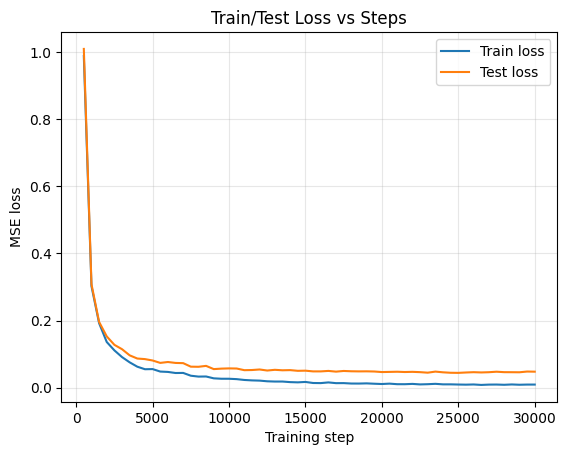

Saved results/loss_vs_steps.png


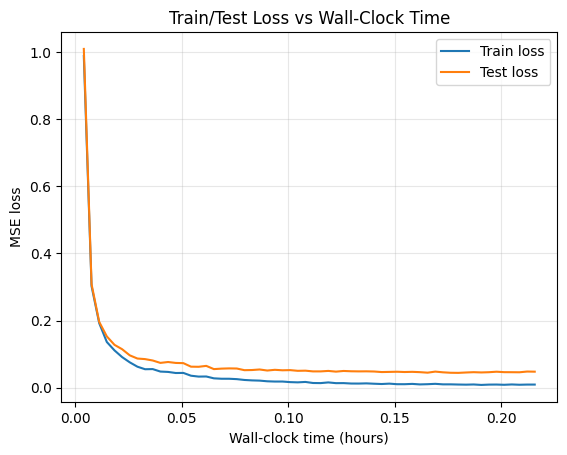

Saved results/loss_vs_time.png


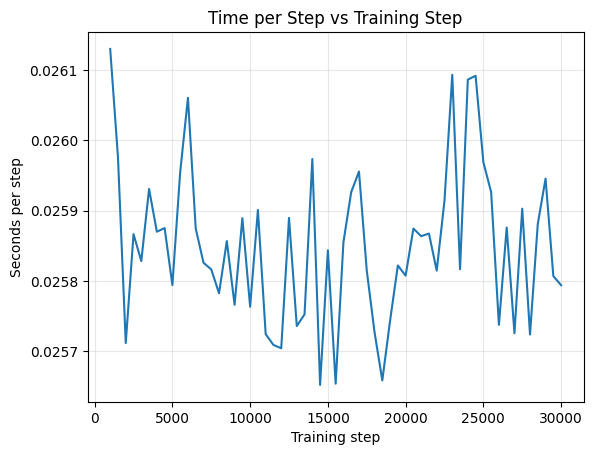

Saved results/time_per_step_vs_steps.png
Mean seconds/step: 0.025850
Std seconds/step: 0.000111


In [ ]:

def plot_history(history_path, save_dir="results"):
    # Load history JSON
    with open(history_path, "r") as f:
        history = json.load(f)

    train_loss = np.array(history["train_loss"])
    test_loss = np.array(history["test_loss"])
    steps = np.array(history["step"])
    wall_time = np.array(history["wall_time"])  # seconds

    os.makedirs(save_dir, exist_ok=True)

    # 1) Loss vs training steps
    plt.figure()
    plt.plot(steps, train_loss, label="Train loss")
    plt.plot(steps, test_loss, label="Test loss")
    plt.xlabel("Training step")
    plt.ylabel("MSE loss")
    plt.title("Train/Test Loss vs Steps")
    plt.legend()
    plt.grid(True, alpha=0.3)
    loss_step_path = os.path.join(save_dir, "loss_vs_steps.png")
    plt.savefig(loss_step_path, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved {loss_step_path}")

    # 2) Loss vs wall-clock time (in hours)
    wall_time_hours = wall_time / 3600.0

    plt.figure()
    plt.plot(wall_time_hours, train_loss, label="Train loss")
    plt.plot(wall_time_hours, test_loss, label="Test loss")
    plt.xlabel("Wall-clock time (hours)")
    plt.ylabel("MSE loss")
    plt.title("Train/Test Loss vs Wall-Clock Time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    loss_time_path = os.path.join(save_dir, "loss_vs_time.png")
    plt.savefig(loss_time_path, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved {loss_time_path}")

    # 3) Time per step (seconds/step) vs step
    #   Δtime between checkpoints / Δsteps
    dt = np.diff(wall_time)         # seconds between logs
    dsteps = np.diff(steps)         # steps between logs (should be constant, e.g. 1000)
    time_per_step = dt / dsteps     # seconds per step
    step_centers = steps[1:]        # align each dt with the later step

    plt.figure()
    plt.plot(step_centers, time_per_step)
    plt.xlabel("Training step")
    plt.ylabel("Seconds per step")
    plt.title("Time per Step vs Training Step")
    plt.grid(True, alpha=0.3)
    tps_path = os.path.join(save_dir, "time_per_step_vs_steps.png")
    plt.savefig(tps_path, bbox_inches="tight")
    plt.show()
    # plt.close()
    print(f"Saved {tps_path}")

    # Optionally print summary stats
    print(f"Mean seconds/step: {time_per_step.mean():.6f}")
    print(f"Std seconds/step: {time_per_step.std():.6f}")

history_path = "results/linear_history.json"  # adjust if needed
plot_history(history_path, save_dir="results")

In [ ]:
config = {
'n_dims': 5, 'n_positions': 10, 'n_embd': 256,
'n_layer': 3, 'n_head': 4, 'batch_size': 32,
'lr': 3e-4, 'steps': 30000,
'data_path': 'isotropic_data.npz',
'checkpoint_path': 'checkpoints/linear_model_3.pt',
'save_path': 'checkpoints/linear_model_3.pt',
'history_path': 'results/linear_history_3.json'
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.makedirs(os.path.dirname(config['save_path']), exist_ok=True)
os.makedirs(os.path.dirname(config['history_path']), exist_ok=True)

train_xs, train_ys, test_xs, test_ys = load_data(config['data_path'])

# model = LinearTransformerModel(config['n_dims'], config['n_positions'],
# config['n_embd'], config['n_layer'], config['n_head']).to(device)

model = LinearAttentionICLModel(config['n_dims'], config['n_positions'],
config['n_embd'], config['n_layer'], config['n_head']).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])

print(f"Training {model.name} on {device}")

history = train_model(model, train_xs, train_ys, test_xs, test_ys, config, device)

with open(config['history_path'], 'w') as f:
        json.dump(history, f, indent=2)



Training linear_attn_embd=256_layer=3_head=4 on cuda

Training for 30000 steps
Batch size: 32
Train samples: 16000, Test samples: 4000



Training:   2%|▏         | 515/30000 [00:07<25:48, 19.04it/s, loss=1.0282]


Step   500 | Train Loss: 0.953865 | Test Loss: 0.961073 | Time: 0.00h
✓ Saved new best model (test_loss: 0.961073)


Training:   3%|▎         | 1015/30000 [00:15<33:49, 14.28it/s, loss=0.5658]


Step  1000 | Train Loss: 0.330317 | Test Loss: 0.326242 | Time: 0.00h
✓ Saved new best model (test_loss: 0.326242)


Training:   5%|▌         | 1516/30000 [00:22<24:33, 19.33it/s, loss=0.5219]


Step  1500 | Train Loss: 0.202914 | Test Loss: 0.202831 | Time: 0.01h
✓ Saved new best model (test_loss: 0.202831)


Training:   7%|▋         | 2015/30000 [00:30<24:07, 19.33it/s, loss=0.4546]


Step  2000 | Train Loss: 0.138830 | Test Loss: 0.148824 | Time: 0.01h
✓ Saved new best model (test_loss: 0.148824)


Training:   8%|▊         | 2516/30000 [00:37<31:49, 14.39it/s, loss=0.4585]


Step  2500 | Train Loss: 0.132976 | Test Loss: 0.141794 | Time: 0.01h
✓ Saved new best model (test_loss: 0.141794)


Training:  10%|█         | 3015/30000 [00:44<31:29, 14.28it/s, loss=0.3005]


Step  3000 | Train Loss: 0.106814 | Test Loss: 0.119916 | Time: 0.01h
✓ Saved new best model (test_loss: 0.119916)


Training:  12%|█▏        | 3516/30000 [00:52<22:56, 19.24it/s, loss=0.3711]


Step  3500 | Train Loss: 0.098987 | Test Loss: 0.117111 | Time: 0.01h
✓ Saved new best model (test_loss: 0.117111)


Training:  13%|█▎        | 4017/30000 [00:59<21:57, 19.72it/s, loss=0.4253]


Step  4000 | Train Loss: 0.091574 | Test Loss: 0.117542 | Time: 0.02h


Training:  15%|█▌        | 4515/30000 [01:07<22:05, 19.22it/s, loss=0.2854]


Step  4500 | Train Loss: 0.080765 | Test Loss: 0.105647 | Time: 0.02h
✓ Saved new best model (test_loss: 0.105647)


Training:  17%|█▋        | 5017/30000 [01:14<20:51, 19.96it/s, loss=0.3321]


Step  5000 | Train Loss: 0.086313 | Test Loss: 0.110011 | Time: 0.02h


Training:  18%|█▊        | 5515/30000 [01:21<21:15, 19.19it/s, loss=0.3342]


Step  5500 | Train Loss: 0.073453 | Test Loss: 0.096832 | Time: 0.02h
✓ Saved new best model (test_loss: 0.096832)


Training:  20%|██        | 6017/30000 [01:29<27:30, 14.53it/s, loss=0.3058]


Step  6000 | Train Loss: 0.074556 | Test Loss: 0.105184 | Time: 0.02h


Training:  22%|██▏       | 6517/30000 [01:36<20:18, 19.28it/s, loss=0.2858]


Step  6500 | Train Loss: 0.067408 | Test Loss: 0.098712 | Time: 0.03h


Training:  23%|██▎       | 7017/30000 [01:44<19:42, 19.44it/s, loss=0.2270]


Step  7000 | Train Loss: 0.066110 | Test Loss: 0.100751 | Time: 0.03h


Training:  25%|██▌       | 7517/30000 [01:51<18:51, 19.87it/s, loss=0.2451]


Step  7500 | Train Loss: 0.060717 | Test Loss: 0.097535 | Time: 0.03h


Training:  27%|██▋       | 8017/30000 [01:58<18:46, 19.51it/s, loss=0.3098]


Step  8000 | Train Loss: 0.058282 | Test Loss: 0.099727 | Time: 0.03h


Training:  28%|██▊       | 8515/30000 [02:06<18:39, 19.20it/s, loss=0.2421]


Step  8500 | Train Loss: 0.059401 | Test Loss: 0.096695 | Time: 0.04h
✓ Saved new best model (test_loss: 0.096695)


Training:  30%|███       | 9015/30000 [02:13<24:18, 14.39it/s, loss=0.3064]


Step  9000 | Train Loss: 0.054501 | Test Loss: 0.100652 | Time: 0.04h


Training:  32%|███▏      | 9515/30000 [02:21<17:52, 19.11it/s, loss=0.2374]


Step  9500 | Train Loss: 0.053922 | Test Loss: 0.095719 | Time: 0.04h
✓ Saved new best model (test_loss: 0.095719)


Training:  33%|███▎      | 10015/30000 [02:28<23:07, 14.40it/s, loss=0.2226]


Step 10000 | Train Loss: 0.050486 | Test Loss: 0.095360 | Time: 0.04h
✓ Saved new best model (test_loss: 0.095360)


Training:  35%|███▌      | 10517/30000 [02:36<16:45, 19.37it/s, loss=0.2680]


Step 10500 | Train Loss: 0.050604 | Test Loss: 0.098662 | Time: 0.04h


Training:  37%|███▋      | 11017/30000 [02:43<16:14, 19.47it/s, loss=0.2141]


Step 11000 | Train Loss: 0.046299 | Test Loss: 0.096145 | Time: 0.05h


Training:  38%|███▊      | 11516/30000 [02:51<21:24, 14.39it/s, loss=0.1827]


Step 11500 | Train Loss: 0.044780 | Test Loss: 0.094361 | Time: 0.05h
✓ Saved new best model (test_loss: 0.094361)


Training:  40%|████      | 12016/30000 [02:58<15:33, 19.27it/s, loss=0.2304]


Step 12000 | Train Loss: 0.044350 | Test Loss: 0.094797 | Time: 0.05h


Training:  42%|████▏     | 12515/30000 [03:05<15:17, 19.05it/s, loss=0.1960]


Step 12500 | Train Loss: 0.042039 | Test Loss: 0.094123 | Time: 0.05h
✓ Saved new best model (test_loss: 0.094123)


Training:  43%|████▎     | 13015/30000 [03:13<19:47, 14.31it/s, loss=0.1767]


Step 13000 | Train Loss: 0.038049 | Test Loss: 0.091830 | Time: 0.05h
✓ Saved new best model (test_loss: 0.091830)


Training:  45%|████▌     | 13517/30000 [03:20<14:03, 19.53it/s, loss=0.1928]


Step 13500 | Train Loss: 0.037269 | Test Loss: 0.095188 | Time: 0.06h


Training:  47%|████▋     | 14017/30000 [03:28<13:44, 19.39it/s, loss=0.1536]


Step 14000 | Train Loss: 0.036757 | Test Loss: 0.094070 | Time: 0.06h


Training:  48%|████▊     | 14517/30000 [03:35<13:21, 19.31it/s, loss=0.1435]


Step 14500 | Train Loss: 0.036915 | Test Loss: 0.097028 | Time: 0.06h


Training:  50%|█████     | 15017/30000 [03:43<13:14, 18.85it/s, loss=0.2103]


Step 15000 | Train Loss: 0.033806 | Test Loss: 0.095418 | Time: 0.06h


Training:  52%|█████▏    | 15515/30000 [03:50<12:36, 19.16it/s, loss=0.2700]


Step 15500 | Train Loss: 0.030380 | Test Loss: 0.090900 | Time: 0.06h
✓ Saved new best model (test_loss: 0.090900)


Training:  53%|█████▎    | 16017/30000 [03:58<12:20, 18.89it/s, loss=0.1285]


Step 16000 | Train Loss: 0.031112 | Test Loss: 0.093812 | Time: 0.07h


Training:  55%|█████▌    | 16517/30000 [04:05<11:33, 19.44it/s, loss=0.1681]


Step 16500 | Train Loss: 0.034230 | Test Loss: 0.098690 | Time: 0.07h


Training:  57%|█████▋    | 17017/30000 [04:13<11:01, 19.62it/s, loss=0.1477]


Step 17000 | Train Loss: 0.029983 | Test Loss: 0.091541 | Time: 0.07h


Training:  58%|█████▊    | 17517/30000 [04:20<10:53, 19.09it/s, loss=0.1185]


Step 17500 | Train Loss: 0.028813 | Test Loss: 0.093245 | Time: 0.07h


Training:  60%|██████    | 18017/30000 [04:27<10:16, 19.43it/s, loss=0.1301]


Step 18000 | Train Loss: 0.028739 | Test Loss: 0.091169 | Time: 0.07h


Training:  62%|██████▏   | 18515/30000 [04:35<09:56, 19.27it/s, loss=0.1849]


Step 18500 | Train Loss: 0.025985 | Test Loss: 0.088024 | Time: 0.08h
✓ Saved new best model (test_loss: 0.088024)


Training:  63%|██████▎   | 19017/30000 [04:42<12:40, 14.44it/s, loss=0.1422]


Step 19000 | Train Loss: 0.025928 | Test Loss: 0.090703 | Time: 0.08h


Training:  65%|██████▌   | 19517/30000 [04:50<11:29, 15.21it/s, loss=0.1331]


Step 19500 | Train Loss: 0.024981 | Test Loss: 0.090675 | Time: 0.08h


Training:  67%|██████▋   | 20017/30000 [04:57<11:27, 14.51it/s, loss=0.1430]


Step 20000 | Train Loss: 0.025248 | Test Loss: 0.091114 | Time: 0.08h


Training:  68%|██████▊   | 20517/30000 [05:05<08:15, 19.13it/s, loss=0.2038]


Step 20500 | Train Loss: 0.023442 | Test Loss: 0.090304 | Time: 0.08h


Training:  70%|███████   | 21017/30000 [05:12<10:23, 14.40it/s, loss=0.1140]


Step 21000 | Train Loss: 0.022720 | Test Loss: 0.091672 | Time: 0.09h


Training:  72%|███████▏  | 21517/30000 [05:20<07:13, 19.57it/s, loss=0.1844]


Step 21500 | Train Loss: 0.021438 | Test Loss: 0.088726 | Time: 0.09h


Training:  73%|███████▎  | 22017/30000 [05:27<06:59, 19.04it/s, loss=0.1130]


Step 22000 | Train Loss: 0.021161 | Test Loss: 0.090835 | Time: 0.09h


Training:  75%|███████▌  | 22516/30000 [05:34<08:40, 14.37it/s, loss=0.1969]


Step 22500 | Train Loss: 0.021516 | Test Loss: 0.091007 | Time: 0.09h


Training:  77%|███████▋  | 23017/30000 [05:42<06:00, 19.38it/s, loss=0.1218]


Step 23000 | Train Loss: 0.021435 | Test Loss: 0.092645 | Time: 0.10h


Training:  78%|███████▊  | 23516/30000 [05:49<05:34, 19.39it/s, loss=0.1402]


Step 23500 | Train Loss: 0.019716 | Test Loss: 0.089519 | Time: 0.10h


Training:  80%|████████  | 24017/30000 [05:57<05:12, 19.15it/s, loss=0.1270]


Step 24000 | Train Loss: 0.019074 | Test Loss: 0.090714 | Time: 0.10h


Training:  82%|████████▏ | 24517/30000 [06:04<06:18, 14.48it/s, loss=0.1479]


Step 24500 | Train Loss: 0.020362 | Test Loss: 0.091110 | Time: 0.10h


Training:  83%|████████▎ | 25017/30000 [06:12<04:16, 19.43it/s, loss=0.1233]


Step 25000 | Train Loss: 0.020833 | Test Loss: 0.090123 | Time: 0.10h


Training:  85%|████████▌ | 25515/30000 [06:19<05:11, 14.38it/s, loss=0.0978]


Step 25500 | Train Loss: 0.017614 | Test Loss: 0.087727 | Time: 0.11h
✓ Saved new best model (test_loss: 0.087727)


Training:  87%|████████▋ | 26016/30000 [06:27<04:38, 14.31it/s, loss=0.1167]


Step 26000 | Train Loss: 0.017169 | Test Loss: 0.086029 | Time: 0.11h
✓ Saved new best model (test_loss: 0.086029)


Training:  88%|████████▊ | 26517/30000 [06:34<02:59, 19.40it/s, loss=0.1281]


Step 26500 | Train Loss: 0.017704 | Test Loss: 0.089885 | Time: 0.11h


Training:  90%|█████████ | 27017/30000 [06:42<02:35, 19.24it/s, loss=0.1396]


Step 27000 | Train Loss: 0.016885 | Test Loss: 0.089674 | Time: 0.11h


Training:  92%|█████████▏| 27517/30000 [06:49<02:08, 19.26it/s, loss=0.1211]


Step 27500 | Train Loss: 0.016480 | Test Loss: 0.087869 | Time: 0.11h


Training:  93%|█████████▎| 28017/30000 [06:56<01:40, 19.68it/s, loss=0.1237]


Step 28000 | Train Loss: 0.018684 | Test Loss: 0.090299 | Time: 0.12h


Training:  95%|█████████▌| 28517/30000 [07:04<01:16, 19.36it/s, loss=0.1119]


Step 28500 | Train Loss: 0.016181 | Test Loss: 0.091596 | Time: 0.12h


Training:  97%|█████████▋| 29017/30000 [07:11<01:07, 14.61it/s, loss=0.0943]


Step 29000 | Train Loss: 0.015347 | Test Loss: 0.091905 | Time: 0.12h


Training:  98%|█████████▊| 29517/30000 [07:19<00:24, 19.61it/s, loss=0.1253]


Step 29500 | Train Loss: 0.015599 | Test Loss: 0.088847 | Time: 0.12h


Training: 100%|██████████| 30000/30000 [07:26<00:00, 67.20it/s, loss=0.1605]


Step 30000 | Train Loss: 0.015240 | Test Loss: 0.089526 | Time: 0.12h


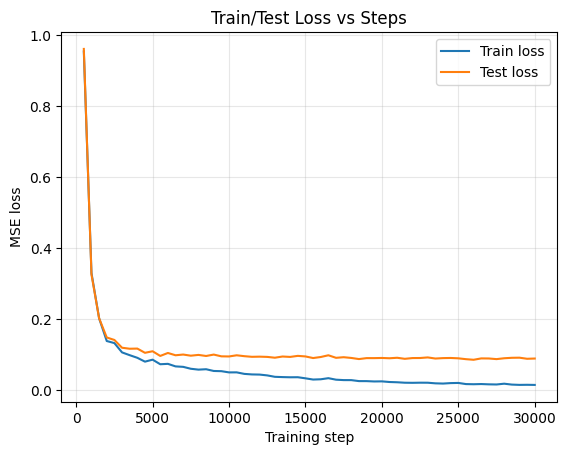

Saved results/loss_vs_steps.png


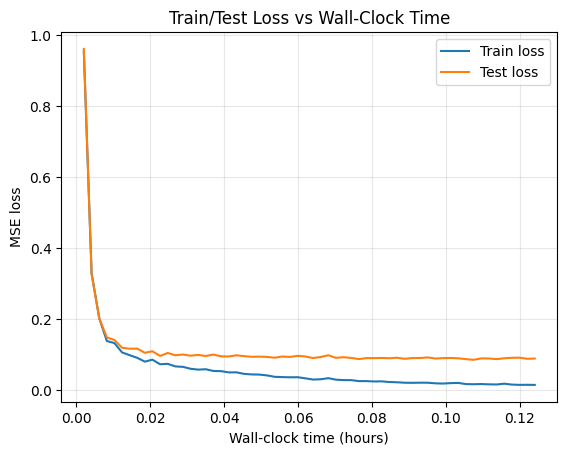

Saved results/loss_vs_time.png


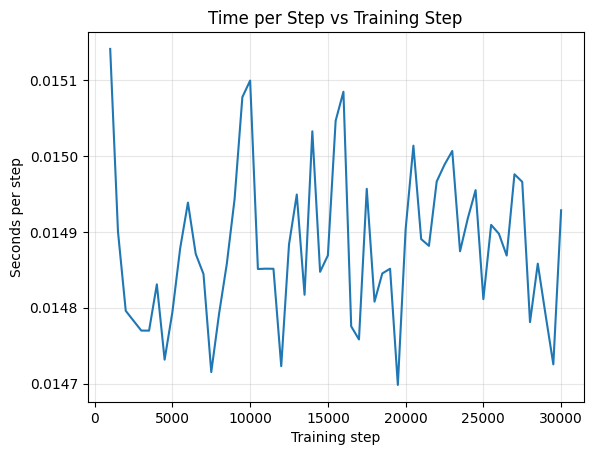

Saved results/time_per_step_vs_steps.png
Mean seconds/step: 0.014880
Std seconds/step: 0.000101


In [ ]:

history_path = "results/linear_history_3.json"
plot_history(history_path, save_dir="results")

In [ ]:
import torch

config = {
'n_dims': 5, 'n_positions': 10, 'n_embd': 256,
'n_layer': 6, 'n_head': 4, 'batch_size': 32,
'lr': 3e-4, 'steps': 30000,
'data_path': 'isotropic_data.npz',
'checkpoint_path': 'checkpoints/linear_model_3.pt',
'save_path': 'checkpoints/linear_model_3.pt',
'history_path': 'results/linear_history_3.json'
}


def count_parameters(model):
    # It is best practice to count only parameters that require grad (trainable)
    # but your original logic counts everything (frozen + trainable).
    return sum(p.numel() for p in model.parameters())

model_path = "linear_model-4.pt"

# 1. Initialize the model architecture
model = LinearAttentionICLModel(config['n_dims'], config['n_positions'])

# 2. Load the weights
state_dict = torch.load(model_path)

# 3. Apply weights to the model (This is an in-place operation)
model.load_state_dict(state_dict)

# 4. Pass the model object itself to the function
print(count_parameters(model))

RuntimeError: Error(s) in loading state_dict for LinearAttentionICLModel:
	Missing key(s) in state_dict: "_read_in.weight", "_read_in.bias", "pos_emb.weight", "layers.0.ln_1.weight", "layers.0.ln_1.bias", "layers.0.attn.qkv_proj.weight", "layers.0.attn.qkv_proj.bias", "layers.0.attn.out_proj.weight", "layers.0.attn.out_proj.bias", "layers.0.ln_2.weight", "layers.0.ln_2.bias", "layers.0.mlp.0.weight", "layers.0.mlp.0.bias", "layers.0.mlp.2.weight", "layers.0.mlp.2.bias", "layers.1.ln_1.weight", "layers.1.ln_1.bias", "layers.1.attn.qkv_proj.weight", "layers.1.attn.qkv_proj.bias", "layers.1.attn.out_proj.weight", "layers.1.attn.out_proj.bias", "layers.1.ln_2.weight", "layers.1.ln_2.bias", "layers.1.mlp.0.weight", "layers.1.mlp.0.bias", "layers.1.mlp.2.weight", "layers.1.mlp.2.bias", "layers.2.ln_1.weight", "layers.2.ln_1.bias", "layers.2.attn.qkv_proj.weight", "layers.2.attn.qkv_proj.bias", "layers.2.attn.out_proj.weight", "layers.2.attn.out_proj.bias", "layers.2.ln_2.weight", "layers.2.ln_2.bias", "layers.2.mlp.0.weight", "layers.2.mlp.0.bias", "layers.2.mlp.2.weight", "layers.2.mlp.2.bias", "layers.3.ln_1.weight", "layers.3.ln_1.bias", "layers.3.attn.qkv_proj.weight", "layers.3.attn.qkv_proj.bias", "layers.3.attn.out_proj.weight", "layers.3.attn.out_proj.bias", "layers.3.ln_2.weight", "layers.3.ln_2.bias", "layers.3.mlp.0.weight", "layers.3.mlp.0.bias", "layers.3.mlp.2.weight", "layers.3.mlp.2.bias", "layers.4.ln_1.weight", "layers.4.ln_1.bias", "layers.4.attn.qkv_proj.weight", "layers.4.attn.qkv_proj.bias", "layers.4.attn.out_proj.weight", "layers.4.attn.out_proj.bias", "layers.4.ln_2.weight", "layers.4.ln_2.bias", "layers.4.mlp.0.weight", "layers.4.mlp.0.bias", "layers.4.mlp.2.weight", "layers.4.mlp.2.bias", "layers.5.ln_1.weight", "layers.5.ln_1.bias", "layers.5.attn.qkv_proj.weight", "layers.5.attn.qkv_proj.bias", "layers.5.attn.out_proj.weight", "layers.5.attn.out_proj.bias", "layers.5.ln_2.weight", "layers.5.ln_2.bias", "layers.5.mlp.0.weight", "layers.5.mlp.0.bias", "layers.5.mlp.2.weight", "layers.5.mlp.2.bias", "layers.6.ln_1.weight", "layers.6.ln_1.bias", "layers.6.attn.qkv_proj.weight", "layers.6.attn.qkv_proj.bias", "layers.6.attn.out_proj.weight", "layers.6.attn.out_proj.bias", "layers.6.ln_2.weight", "layers.6.ln_2.bias", "layers.6.mlp.0.weight", "layers.6.mlp.0.bias", "layers.6.mlp.2.weight", "layers.6.mlp.2.bias", "layers.7.ln_1.weight", "layers.7.ln_1.bias", "layers.7.attn.qkv_proj.weight", "layers.7.attn.qkv_proj.bias", "layers.7.attn.out_proj.weight", "layers.7.attn.out_proj.bias", "layers.7.ln_2.weight", "layers.7.ln_2.bias", "layers.7.mlp.0.weight", "layers.7.mlp.0.bias", "layers.7.mlp.2.weight", "layers.7.mlp.2.bias", "_read_out.weight", "_read_out.bias". 
	Unexpected key(s) in state_dict: "step", "model_state_dict", "test_loss", "wall_time". 